In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [3]:
citations = pd.read_csv("old_citations.csv")
citations.head()

,source,target
0,94ac58d1b6132b07ef66c47af8bd506bdb67e0c3,09895f8b8e38dba2d62d742541778c97c91d97ce
1,94ac58d1b6132b07ef66c47af8bd506bdb67e0c3,0cb85c72ea11c067adbdf47e006cd51bd3065ea5
2,94ac58d1b6132b07ef66c47af8bd506bdb67e0c3,12463ae88245b865eaa11ef632132fb90d187a34
3,94ac58d1b6132b07ef66c47af8bd506bdb67e0c3,1f089bb17a848f6cf6d90da330352928cd6a4045
4,94ac58d1b6132b07ef66c47af8bd506bdb67e0c3,26ae952599aa9ba5815a80356024258247fc2b10


In [4]:
paper_data = pd.read_csv("old_paper_data.csv")
paper_data.embedding = paper_data.embedding.apply(eval).apply(np.array)
paper_data.head()

,paperId,title,embedding
0,60fa56348f34b154b153322ad7322d0dc2943b52,Tree and spline based association analysis of ...,"[-2.880059242248535, -5.015457630157471, -1.99..."
1,d64a1588bc3dacfeacf39ff1fa543c6832e051e2,Optimally combining sampling techniques for Mo...,"[-2.3202474117279053, -1.4120348691940308, 0.3..."
2,5c54fa8123e1e73cad9a2bd313588985cef5a5ea,Detecting gene–gene interactions that underlie...,"[-2.3627116680145264, -6.266533851623535, 0.87..."
3,7582eecc3747f784151e3043ae2edae3e1cd4825,A genetic programming-based approach to the cl...,"[0.2626941204071045, -3.9721202850341797, -2.2..."
4,75eabf87520b2f8a6258a849db6efa4b3caec6ea,Which tone-mapping operator is the best? A com...,"[-1.3394620418548584, -6.056660175323486, -2.3..."


In [5]:
og = citations.source[0]
og_embedding = paper_data.embedding[paper_data.paperId == og].values[0]

reference_embeddings = pd.merge(citations, paper_data, left_on="target", right_on="paperId")[["source", "embedding"]]
relevant = np.array(reference_embeddings.source == og)
embeddings = np.vstack(reference_embeddings.embedding.values)

print(relevant.shape)
print(embeddings.shape)

reference_embeddings

IndexError: index 0 is out of bounds for axis 0 with size 0

In [145]:
x, x_test, y, y_test = train_test_split(embeddings, relevant, test_size=0.2, random_state=42, stratify=relevant)
model = LogisticRegression()
model.fit(x, y)
print("train score", model.score(x, y))
print("test score", model.score(x_test, y_test))
print("base rate", 1 - relevant.mean())

print()
print("n_train_relevant:", y.sum())
print("n_train_irrelevant:", (~y).sum())
print("n_test_relevant:", y_test.sum())
print("n_test_irrelevant:", (~y_test).sum())

print("\ntest confusion matrix")
print(confusion_matrix(y_test, model.predict(x_test)))

train score 1.0
test score 0.967741935483871
base rate 0.8506493506493507

n_train_relevant: 37
n_train_irrelevant: 209
n_test_relevant: 9
n_test_irrelevant: 53

test confusion matrix
[[52  1]
 [ 1  8]]


/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [154]:
x, x_test, y, y_test = train_test_split(np.abs(embeddings - og_embedding), relevant, test_size=0.2, random_state=42, stratify=relevant)
model = LogisticRegression()
model.fit(x, y)
print("train score", model.score(x, y))
print("test score", model.score(x_test, y_test))
print("base rate", 1 - relevant.mean())

train score 1.0
test score 0.9193548387096774
base rate 0.8506493506493507


/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


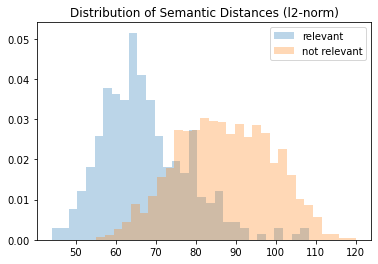

In [146]:
good = []
bad = []

for source_paper in np.unique(citations.source):
    source_embedding = paper_data.embedding[paper_data.paperId == source_paper].values[0]
    distances = np.linalg.norm(embeddings - source_embedding, axis=1)
    good.extend(distances[reference_embeddings.source == source_paper])
    bad.extend(distances[reference_embeddings.source != source_paper])

good = np.array(good)
bad = np.array(bad)

plt.hist(good, bins=30, alpha=0.3, label="relevant", density=True)
plt.hist(bad, bins=30, alpha=0.3, label="not relevant", density=True)
plt.legend()
plt.title("Distribution of Semantic Distances (l2-norm)")
plt.show()

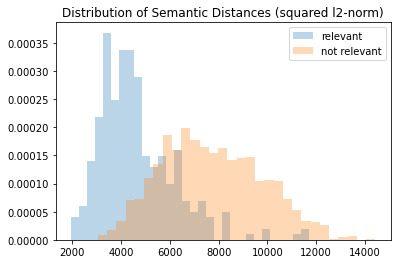

In [153]:
plt.hist(good**2, bins=30, alpha=0.3, label="relevant", density=True)
plt.hist(bad**2, bins=30, alpha=0.3, label="not relevant", density=True)
plt.legend()
plt.title("Distribution of Semantic Distances (squared l2-norm)")
plt.show()

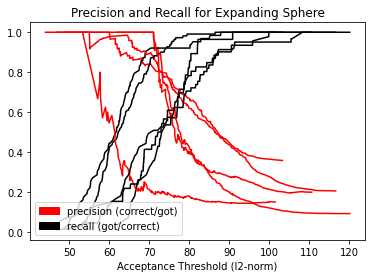

In [155]:
plt.figure(figsize=(6, 4))

for source_paper in np.unique(citations.source):
    source_embedding = paper_data.embedding[paper_data.paperId == source_paper].values[0]
    distances = np.linalg.norm(embeddings - source_embedding, axis=1)
    relevant_here = reference_embeddings.source == source_paper

    dist_sort = np.argsort(distances)
    relevant_sorted = relevant_here[dist_sort]

    precision = np.cumsum(relevant_sorted) / (np.arange(len(relevant_sorted)) + 1)
    recall = np.cumsum(relevant_sorted) / relevant_sorted.sum()

    plt.plot(distances[dist_sort], precision, color="red")
    plt.plot(distances[dist_sort], recall, color="black")

plt.legend(handles=[Patch(color="red", label="precision (correct/got)"), Patch(color="black", label="recall (got/correct)")])
plt.title("Precision and Recall for Expanding Sphere")
plt.xlabel("Acceptance Threshold (l2-norm)")
plt.show()